In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import yaml

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams

logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

Подгружаем датасет, получнный в результате эксперимента

In [2]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


In [3]:
df.shape

(200000, 13)

Описание эксперимента и датасета

In [4]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    cluster_col='cluster_id', 
    clustering_cols=['col1', 'col2', 'col3'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    split_ratios=(0.5, 0.5), 
    strategy='simple_test', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

# Кейс №1. Постанализ

In [5]:
df = pd.read_csv('./data/ab_data.csv')

In [6]:
ab_test = ABTest(df, ab_params)

In [7]:
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test.test_hypothesis_ttest()}")

bootstrap_test: {'stat': None, 'p-value': array([0.31734699]), 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
ttest_test: {'stat': -0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [8]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.001, 
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

In [9]:
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test.test_hypothesis_ttest()}")

bootstrap_test: {'stat': None, 'p-value': array([2.01270523e-13]), 'result': 1}
mannwhitney_test: {'stat': 4894119324.0, 'p-value': 2.4516264484905984e-16, 'result': 1}
ttest_test: {'stat': -8.275588883468059, 'p-value': 1.2859564365137272e-16, 'result': 1}


# Кейс №2. Постанализ с понижением дисперсии. CUPED

In [10]:
df = pd.read_csv('./data/ab_data.csv')

Увеличиваем количество прокрасов в тестовой группе

In [11]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.0001, 
                                            axis=0,
                                            inplace=True)

# тесты без понижения дисперсии
ab_test = ABTest(df, ab_params)
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test.test_hypothesis_ttest()}")


# тесты с понижением дисперсии
ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_hypothesis_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_hypothesis_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_hypothesis_ttest()}")

bootstrap_test: {'stat': None, 'p-value': array([0.11901154]), 'result': 0}
mannwhitney_test: {'stat': 4983082845.0, 'p-value': 0.19137136312943093, 'result': 0}
ttest_test: {'stat': -1.2271064134922398, 'p-value': 0.21978404218147798, 'result': 0}
bootstrap_test: {'stat': None, 'p-value': array([0.00087175]), 'result': 1}
mannwhitney_test: {'stat': 4962621356.0, 'p-value': 0.0038343556323012554, 'result': 1}
ttest_test: {'stat': -3.3123079503060633, 'p-value': 0.0009254602801692166, 'result': 1}


# Кейс №3. Постанализ для бинарной переменной

In [12]:
df = pd.read_csv('./data/ab_data.csv')

In [13]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country',
    target='conversion', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    cluster_col='kl-divergence', 
    clustering_cols=['col1', 'col2', 'col3'], 
    is_grouped=True
)


hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    split_ratios=(0.5, 0.5), 
    strategy='simple_test', 
    strata='country', 
    strata_weights={'1': 0.8, '2': 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params,hypothesis_params)

In [14]:
ab_test = ABTest(df, ab_params)

In [15]:
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test.test_hypothesis_ztest_prop()}")

bootstrap_test: {'stat': None, 'p-value': array([0.24577016]), 'result': 0}
ztest_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [16]:
df['conversion'] = np.where(df.noise_now < 0, 0, 1)
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            np.random.binomial(n=1, p=0.98, size=df.shape[0]),
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test.test_hypothesis_ztest_prop()}")

bootstrap_test: {'stat': None, 'p-value': array([5.05460207e-263]), 'result': 1}
ztest_test: {'stat': -33.72037507170561, 'p-value': 2.906848560640323e-249, 'result': 1}


# Кейс №4. Понижение дисперсии для конверсии

<span style="color: red;">CUPED не работает с конверсией!</span>

In [17]:
df = pd.read_csv('./data/ab_data.csv')

In [18]:
ab_test = ABTest(df, ab_params)
print(f"bootstrap_test: {ab_test.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test.test_hypothesis_ztest_prop()}")


ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_hypothesis_boot_confint()}")
print(f"ztest_test: {ab_test1.test_hypothesis_ztest_prop()}")

bootstrap_test: {'stat': None, 'p-value': array([0.23948382]), 'result': 0}
ztest_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}
bootstrap_test: {'stat': None, 'p-value': array([0.25219384]), 'result': 0}
ztest_test: {'stat': -0.6730634505956524, 'p-value': 0.5009069250619678, 'result': 0}


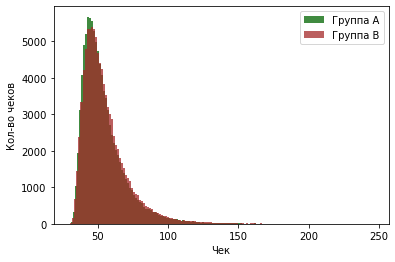

In [19]:
import matplotlib.pyplot as plt

np.random.seed(42)

n_obs = 100_000
d1 = np.random.lognormal(3, 0.6, n_obs) + np.random.normal(0, 1, n_obs) + np.array([30] * n_obs)
d2 = np.random.lognormal(3.05, 0.6, n_obs) + np.random.normal(0, 1, n_obs) + np.array([30] * n_obs)

d1 = d1[d1 < 250]
d2 = d2[d2 < 250]

plt.hist(d1, bins=150, alpha=0.75, label='Группа А', color='darkgreen')
plt.hist(d2, bins=150, alpha=0.75, label='Группа В', color='brown')
plt.xlabel('Чек')
plt.ylabel('Кол-во чеков')
plt.legend()
plt.show()